# 2020 Spring CS_349 Machine Learning Final Project
## Covid-19 Cases Data Analysis with K-Means and RNN

####                                                                                                                                                              Author: Dachuan Zuo

### Table of Contents:
#### 1. Load Data
#### 2. K-Means Modeling for States' Cases Growth Pattern Classification
#### 3. RNN Modeling for States' Cases Growth Forecast in the Future 30 Days
#### 4. Result Evaluation

In [64]:
import sys
sys.path.insert(0, '..')
from utils import data
import os
os.path.abspath('')
import sklearn
import numpy as np
import json
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, date
import geoplot as gplot
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

## 1. Load Data
This final project mainly uses three datasets. Two datasets, "time_series_covid19_confirmed_global.csv" and "time_series_covid19_confirmed_us.csv" are contained in the provided final project folder. The "us-states.csv" dataset is a dataset contributed by Alberstun in his public Github repository, which contains the up-to-date number of tested, confirmed, and dead cases of COVID-19. Here's a link to this dataset https://github.com/nytimes/covid-19-data/blob/master/us-states.csv. You can also find it in the repository of this project. 

The two methods as below are used to import these datasets from the project's working directory and group them into two array-like structures which are later used in the training and testing. Both of them return a feature array which contains pure data and an array of corresponding states. 

In [27]:
def import_US_confirmed():
    BASE_PATH = r'C:/Users/Lucas/COVID/test1/coronavirus-2020/COVID-19/csse_covid_19_data/'
    MIN_CASES = 1000
    # ------------------------------------------
    
    confirmed = os.path.join(
        BASE_PATH, 
        'csse_covid_19_time_series',
        'time_series_covid19_confirmed_US.csv')
    confirmed = data.load_csv_data(confirmed)
    state_feature = {}
    states = list(set(confirmed["Province_State"]))
    # print (confirmed.iloc[232,11:confirmed.shape[0]-11])
    
    for idx in range(confirmed.shape[0]):
        if confirmed["Province_State"][idx] in list(state_feature.keys()):
            state_feature[confirmed["Province_State"][idx]] += confirmed.iloc[idx,11:confirmed.shape[0]-11]
        else:
            state_feature[confirmed["Province_State"][idx]] = confirmed.iloc[idx,11:confirmed.shape[0]-11]
    features = np.asarray(list(state_feature.values()))
    targets = np.asarray(list(state_feature.keys()))
    return features, targets

def import_US_confirmed_update():
    BASE_PATH = r'C:/Users/Lucas/COVID/test1/coronavirus-2020/COVID-19/csse_covid_19_data/'
    MIN_CASES = 1000

    confirmed = os.path.join(
        BASE_PATH, 
        'csse_covid_19_time_series',
        'us-states.csv')
    confirmed = data.load_csv_data(confirmed)
    dates = sorted(list(set(confirmed["date"])))
    _confirmed = os.path.join(
        BASE_PATH, 
        'csse_covid_19_time_series',
        'time_series_covid19_confirmed_US.csv')
    _confirmed = data.load_csv_data(_confirmed)
    state_feature = {}
    states = list(set(_confirmed["Province_State"]))
    state_feature = dict((state,np.zeros(len(dates))) for state in states)
    for idx in range(confirmed.shape[0]):
        # print ((datetime.strptime(confirmed["date"][idx], '%Y-%m-%d').date() - date(2020,1,21)).days)
        state_feature[confirmed["state"][idx]][(datetime.strptime(confirmed["date"][idx], '%Y-%m-%d').date() - date(2020,1,21)).days] =\
            confirmed["cases"][idx]
    features = np.asarray(list(state_feature.values()))
    targets = np.asarray(list(state_feature.keys()))
    return features, targets

## 2. K-Means Modeling for States' Cases Growth Pattern Classification

In this sector, we build a K-Means model to classify the COVID-19 cases growth pattern of each state. K-Means is superior to KNN in that the former could easily give a sense of how each state's pattern is close or different from any other's.  

Below is a function we use to build such a K-Means model in which "4" is chosen for the number of clusters to give the best visual effect after our repeated trials. This function also contains the used for visualization, which involves using "geoplot" and "mapclassify" packages. 

In [72]:
def kmeans_usa_states():
    from sklearn.cluster import KMeans
        # ------------ HYPERPARAMETERS -------------
    BASE_PATH = r'C:/Users/Lucas/COVID/test1/coronavirus-2020/COVID-19/csse_covid_19_data/'
    MIN_CASES = 1000
    # ------------------------------------------
    
    confirmed = os.path.join(
        BASE_PATH, 
        'csse_covid_19_time_series',
        'time_series_covid19_confirmed_US.csv')
    confirmed = data.load_csv_data(confirmed)
    state_feature = {}
    states = list(set(confirmed["Province_State"]))
    # print (confirmed.iloc[232,11:confirmed.shape[0]-11])
    
    for idx in range(confirmed.shape[0]):
        if confirmed["Province_State"][idx] in list(state_feature.keys()):
            state_feature[confirmed["Province_State"][idx]] += confirmed.iloc[idx,11:confirmed.shape[0]-11]
        else:
            state_feature[confirmed["Province_State"][idx]] = confirmed.iloc[idx,11:confirmed.shape[0]-11]
    features = np.asarray(list(state_feature.values()))
    targets = np.asarray(list(state_feature.keys()))
            
    contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
    contiguous_usa["class"] = np.full(contiguous_usa.shape[0], -1)            
     
    kmeans = KMeans(n_clusters=4, max_iter=1000)
    kmeans.fit(features, targets)
    state_classes = kmeans.predict(features)
     
    state_classes = dict((targets[idx], state_classes[idx]) for idx in range(targets.shape[0]))
    for idx in range(contiguous_usa.shape[0]):
        if contiguous_usa["state"][idx] in targets:
            contiguous_usa["class"][idx] = state_classes[contiguous_usa["state"][idx]]
    df_means = contiguous_usa[["state","class"]]    
                  
    c = mcolors.ColorConverter().to_rgb
    '''
    rvb = make_colormap(
    [ c('orange'), c('violet'), 0.33, c('violet'), 0.50, c('blue'), 0.66, c('red'),c('green')])
    '''
    scheme = mapclassify.NaturalBreaks(list(df_means["class"]))
    gplt.choropleth(
    contiguous_usa, hue=list(df_means["class"]), scheme=scheme, 
      figsize=(8, 4),legend=False,cmap = 'binary'
    )

## 3. RNN Modeling for States' Cases Growth Forecast in the Future 30 Days

In this sector, two Recurrent Nerual Networks (RNNs) with Long Short Term Memory (LSTM) are built to predict the growth of COVID-19 cases within a given state in the short or a longer future. We also use "Keras" to facilitate the modeling. 

The first RNN is designed to forecast the number of cases in the next day by simply looking at today's cases. The first of the two functions below is used to reshape the dataset to work with "Keras". The value of argument "look_back" determines how many days the RNN looks into to make a prediction for the following day. The number of LSTM units is chosen to be 16 for the best practice.

In [17]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

def LSTM_forecast(state):
    features, states = import_US_confirmed()
    features = features[np.where(states == state)[0][0]]
    trainX, trainY = create_dataset(features)
    testX, testY = create_dataset(features)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(1, 1), activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    timespan = pd.date_range("2020-01-22", periods=117).to_list()
    timespan = [str(date.date()) for date in timespan]
    # from matplotlib.dates import date2num
    # timespan =  date2num(timespan)
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(timespan))) 
    ax.set_xticklabels(timespan)
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.plot(timespan, testY, label="True Cases")
    ax.plot(timespan, testPredict, label="Predicted Cases by LSTM")
    # ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.legend()
    plt.gcf().autofmt_xdate()

    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 30 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
    plt.show()

The script below shows our methods to build the second RNN, which is designed to predict the case growth in a longer future. It predicts a sequence of number of cases by looking into a series of past cases. The first function below is used to reshape the dataset to work with "Keras" like that function in the first RNN does. It takes two arguments besides the dataset. "num_x" is the number of days the RNN looks into to make a prediction, and "num_y" controls how many days of cases the RNN needs to predict. Basically, they have the same meaning with the "x_days" and "y_days" in the following function. For example, if these two arguments are set to be 75 and 30 respectively, then the RNN being built will forecast the cases growth of the next 30 days based on the past 75 days' observations.


In [ ]:
def create_dataset_long_term(dataset, num_x, num_y):
    dataX, dataY, testX = [], [], []
    for i in range(len(dataset)-num_x-num_y+1):
        a = dataset[i:(i+num_x)]

        testX.append(dataset[i+num_y:i+num_x+num_y])
        dataX.append(a)
        dataY.append(dataset[i + num_x: i+num_x+num_y])
    return np.array(dataX), np.array(dataY), np.array(testX)

def LSTM_forecast_long_term(state,x_days,y_days):
    features, states = import_US_confirmed()
    features = features[np.where(states == state)[0][0]]
    features_update, states_update = import_US_confirmed_update()
    features_update = features_update[np.where(states_update == state)[0][0]]
    trainX, trainY, testX = create_dataset_long_term(features,x_days,y_days)
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(1024, input_shape=(1, x_days), activation="relu"))
    model.add(Dense(y_days))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    timespan = pd.date_range("2020-01-22", "2020-05-19").to_list()
    timespan = [str(date.date()) for date in timespan]
    timespan_update = pd.date_range("2020-01-21", "2020-06-08").to_list()
    timespan_update = [str(date.date()) for date in timespan_update]
    # print (testPredict)
    forecast_timespan = pd.date_range("2020-05-19", periods = y_days + 1).to_list()
    forecast_timespan = [str(date.date()) for date in forecast_timespan]
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(timespan_update))) 
    ax.set_xticklabels(timespan_update)
    
    ax.plot(timespan_update,features_update, label="True Cases 2020-05-20 ~ 2020-06-08")
    # plt.plot(range(0,x_days), testX[-1][0])
    

     
    ax.plot(forecast_timespan, np.insert(testPredict[-1], 0, features[-1]), label="Predicted Cases by LSTM 2020-05-20 ~ 2020-06-19")
    ax.plot(timespan, features, label = "Trained Cases 2020-01-21 ~ 2020-05-19")
    ax.legend()
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 30 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)


    plt.show()

In [20]:
def smooth(x,window_len=11,window='hanning'):
   

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

## 4. Result Evaluation
This sector provides a showcase of how these methods work with the our actual COVID-19 datasets. 

##### Use the K-Means to classify cases growth pattern of each state:

C:\Anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\envs\coronavirus\lib\site-packages\mapclassify\classifiers.py:1718: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
C:\Anaconda3\envs\coronavirus\lib\site-packages\mapclassify\classifiers.py:1719: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % uvk, UserWarning)


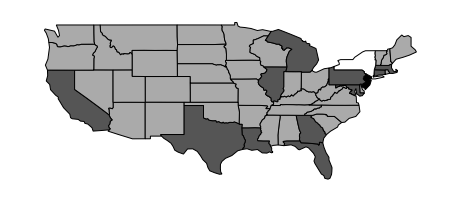

In [74]:
kmeans_usa_states()

There are totally 4 depths of shades in the figure above. States with a similar pattern of cases growth are with the same shade level. The figure highlights 11 states including, California, Illinois, Michigan, Texas, Massachusetts, Florida, and New Jersy, etc, follow similar patterns of COVID-19 case growth. On the other hand, the New York state is alone in one class, meaning that it may follow a very unique pattern which might be hard to compare with other states' situations.

##### Use RNN to forecast cases growth of California in short future:

Epoch 1/100
 - 0s - loss: 783728958.6646
Epoch 2/100
 - 0s - loss: 361501947.0039
Epoch 3/100
 - 0s - loss: 61886303.5324
Epoch 4/100
 - 0s - loss: 437875.9530
Epoch 5/100
 - 0s - loss: 311285.4174
Epoch 6/100
 - 0s - loss: 326585.1677
Epoch 7/100
 - 0s - loss: 320738.6657
Epoch 8/100
 - 0s - loss: 321022.4243
Epoch 9/100
 - 0s - loss: 300775.2389
Epoch 10/100
 - 0s - loss: 332661.8525
Epoch 11/100
 - 0s - loss: 316264.8925
Epoch 12/100
 - 0s - loss: 308390.0110
Epoch 13/100
 - 0s - loss: 324086.4940
Epoch 14/100
 - 0s - loss: 320148.6190
Epoch 15/100
 - 0s - loss: 328833.8617
Epoch 16/100
 - 0s - loss: 360619.4943
Epoch 17/100
 - 0s - loss: 318449.2082
Epoch 18/100
 - 0s - loss: 301613.8392
Epoch 19/100
 - 0s - loss: 315734.5778
Epoch 20/100
 - 0s - loss: 321058.3638
Epoch 21/100
 - 0s - loss: 304376.0010
Epoch 22/100
 - 0s - loss: 301066.3910
Epoch 23/100
 - 0s - loss: 323187.4836
Epoch 24/100
 - 0s - loss: 341272.0294
Epoch 25/100
 - 0s - loss: 288540.4851
Epoch 26/100
 - 0s - loss:

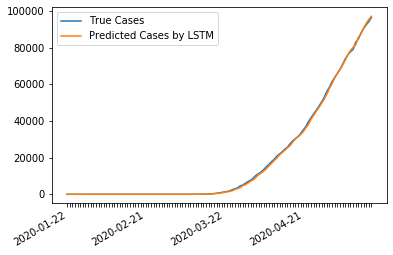

In [30]:
LSTM_forecast("California")

The orange curve in the figure above is the trend predicted by the RNN using only one day's number. It matches the curve of true cases generally well, though in fact the mean squared error is around 300 thousand.

##### Use RNN to forecast cases growth of California in short future:

Epoch 1/100
 - 2s - loss: 2158462523.7333
Epoch 2/100
 - 1s - loss: 1214758638.9333
Epoch 3/100
 - 1s - loss: 325732305.8667
Epoch 4/100
 - 1s - loss: 131300163.4667
Epoch 5/100
 - 1s - loss: 104209433.5833
Epoch 6/100
 - 1s - loss: 92331020.0667
Epoch 7/100
 - 1s - loss: 75280654.6833
Epoch 8/100
 - 1s - loss: 66388829.7792
Epoch 9/100
 - 1s - loss: 54955021.9333
Epoch 10/100
 - 1s - loss: 40354986.3333
Epoch 11/100
 - 1s - loss: 35725995.0250
Epoch 12/100
 - 1s - loss: 28488542.6333
Epoch 13/100
 - 1s - loss: 25390757.3417
Epoch 14/100
 - 1s - loss: 22070295.1333
Epoch 15/100
 - 1s - loss: 18454095.3333
Epoch 16/100
 - 1s - loss: 16909671.6750
Epoch 17/100
 - 1s - loss: 15307987.0333
Epoch 18/100
 - 1s - loss: 13761540.1083
Epoch 19/100
 - 1s - loss: 12831123.0208
Epoch 20/100
 - 1s - loss: 12146528.3833
Epoch 21/100
 - 1s - loss: 11023533.6917
Epoch 22/100
 - 1s - loss: 10550332.6479
Epoch 23/100
 - 1s - loss: 10339787.0000
Epoch 24/100
 - 1s - loss: 9553627.5500
Epoch 25/100
 - 1s 

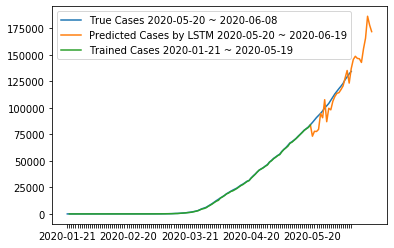

In [63]:
LSTM_forecast_long_term("California",75,30)

The orange curve in the figure above shows the prediction of COVID-19 cases in the 30 days following May 20,2020. The green curve is the time series data of cases used for training, and the blue curve shows the actual trend of cases following May 20,2020. Although the final mean squared error was around 3 million, which is high due to the model is trained by and forecasting a sequence of cases instead of a sinlge number, we choose to finish the training after only 100 epochs. The model tends to be overfitting the training dataset after 200 epochs, although the loss can drop to below 200 thousand after 1000 epochs. 

Another thing to notice is that the predicted curve actually drops at some point, which conflict with our assumptions that the incremental number of cases can never be reduced. However, a machine learning model may not consider that rule like a human does. One solution we suggest to solve this problem is to add a filtering layer next to the full connected layer (Dense()), which smooths the predicted sequence to comply with a exponential function or a linear function. Another solution that seems plausible involves using a different approach to calculate the loss. An output sequence after an epoch in which a decrease seems to happen should be given very a high loss so that we tell our machine that outcome is less acceptable.  